In [110]:
%load_ext autoreload
%autoreload 2 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn


DIR = '/data2/ev/NASA/v2_advanced'
filename = 'RW03'
df = pd.read_parquet(os.path.join(DIR, filename+'.parquet'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OCV labeling using Ref type C

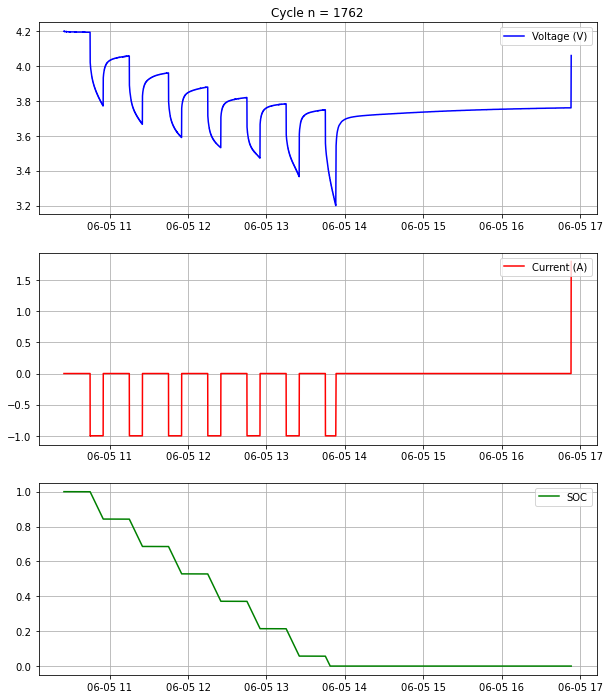

In [114]:
n = 1762
_df = df.loc[df['N'] == n].copy()

fig = plt.figure(figsize=(10, 12))

plt.title(f'Cycle n = {n}')
plt.axis('off')

ax = fig.add_subplot(311)
ax.plot(_df.index, _df['V'], c='blue', label='Voltage (V)')
ax.grid()
ax.legend(loc='upper right')

ax = fig.add_subplot(312)
ax.plot(_df.index, _df['I'], c='red', label='Current (A)')
ax.grid()
ax.legend(loc='upper right')

ax = fig.add_subplot(313)
ax.plot(_df.index, _df['SOC'], c='green', label='SOC')
ax.grid()
ax.legend(loc='upper right')

plt.show()

fig.savefig(f'NASA_Ref_C_n={n}.png', dpi=400)


In [111]:
_df = df.loc[df['ref_type'] == 'C']
_df = _df.loc[(_df['I'] > -0.5) & (_df['I'].shift(-1) < -0.5)].copy()
_df.loc[:, 'OCV'] = _df['V']
_df = _df.loc[:, ['N', 'SOH', 'SOC', 'OCV']]
_df

,N,SOH,SOC,OCV
t,,,,
2021-01-03 20:23:35,6,0.986909,1.000000,4.196
2021-01-03 20:53:35,6,0.986818,0.916975,4.117
2021-01-03 21:23:35,6,0.986726,0.833876,4.050
2021-01-03 21:53:35,6,0.986635,0.750760,3.991
2021-01-03 22:23:35,6,0.986543,0.667628,3.938
...,...,...,...,...
2021-06-05 11:45:01,1762,0.522278,0.685875,3.960
2021-06-05 12:15:01,1762,0.522240,0.528749,3.879
2021-06-05 12:45:01,1762,0.522202,0.371601,3.819


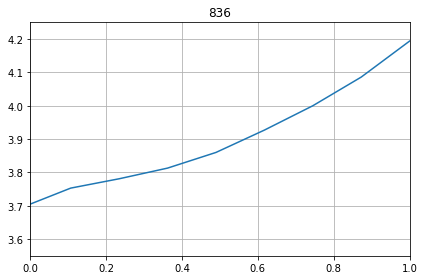

In [90]:
_df_N = _df['N'].drop_duplicates().values
plt.figure(facecolor='white')
def animate(i):
    plt.cla()
    plt.xlim([0., 1.])
    plt.ylim([3.55, 4.25])
    part_df = _df.loc[_df['N'] == _df_N[i]]
    plt.plot(part_df['SOC'], part_df['OCV'])
    plt.title(_df_N[i])
    plt.grid()
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=len(_df_N), interval=1)
ani.save(f'SOC-OCV_{filename}.gif', fps=4)

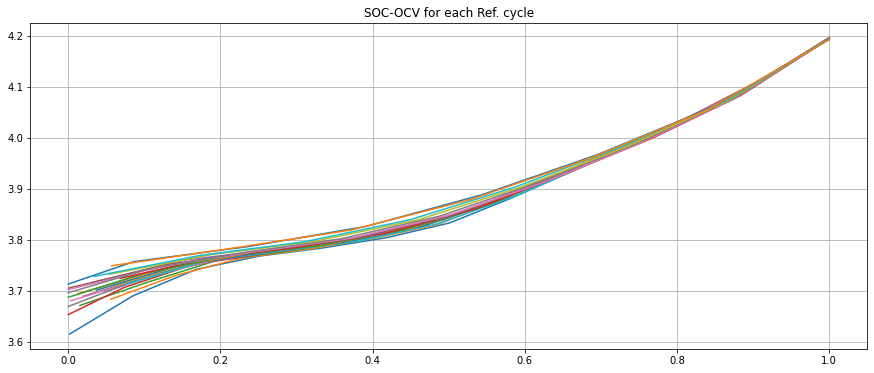

In [64]:
fig = plt.figure(figsize=(15, 6))
_df_N = _df['N'].drop_duplicates().values
for n in _df_N:
    part_df = _df.loc[_df['N'] == n]
    plt.plot(part_df['SOC'], part_df['OCV'], label=n)
plt.grid()
# plt.legend()
plt.title('SOC-OCV for each Ref. cycle')
plt.show()

In [12]:
# train: RW03, RW04, RW05
# test: RW06
from tqdm import tqdm

lookup_dict = {}
for filenum in tqdm([3, 4, 5, 6]):
    filename = f'RW{filenum:02d}'
    df = pd.read_parquet(os.path.join(DIR, filename+'.parquet'))
    _df = df.loc[df['ref_type'] == 'C']
    _df = _df.loc[(_df['I'] > -0.5) & (_df['I'].shift(-1) < -0.5)].copy()
    _df.loc[:, 'OCV'] = _df['V']
    _df = _df.loc[:, ['N', 'SOH', 'SOC', 'OCV']]

    lookup_list = []
    _df_N = _df['N'].drop_duplicates().values
    for n in _df_N:
        part_df = _df.loc[_df['N'] == n].copy()
        Xy = part_df.loc[:, ['SOC', 'OCV']].values
        X_train = Xy[:, [0]]
        y_train = Xy[:, 1]

        poly = PolynomialFeatures(degree=5, include_bias=True)
        X_train_poly = poly.fit_transform(X_train)
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_poly, y_train)
        a0 = lin_reg.intercept_
        a1 = lin_reg.coef_[0]
        a2 = lin_reg.coef_[1]
        a3 = lin_reg.coef_[2]
        a4 = lin_reg.coef_[3]
        a5 = lin_reg.coef_[4]

        conti_X = np.linspace(0.0, 1.0, 1001).reshape(-1, 1)
        conti_X_poly = poly.fit_transform(conti_X)
        y_pred = lin_reg.predict(conti_X_poly)

        avg_SOH = part_df['SOH'].mean()
        lookup = pd.DataFrame(
            np.concatenate([conti_X, np.expand_dims(y_pred, 1)], axis=1),
            columns=['SOC', 'OCV'],
        )
        lookup.loc[:, 'SOH'] = avg_SOH
        lookup_list.append(lookup.loc[:, ['SOH', 'SOC', 'OCV']])
        
    lookup_list = np.concatenate(lookup_list, axis=0)
    lookup_dict[filenum] = lookup_list



# fig = plt.figure(figsize=(10, 7))
# plt.plot(X_train, y_train, label='train')
# plt.plot(conti_X, y_pred, label='pred')
# plt.legend()
# plt.title(f'(n={n}) {a0:.3f} + {a1:.3f}x + {a2:.3f}x**2 + {a3:.3f}x**3 + {a4:.3f}x**4')
# plt.show()
# fig.savefig('SOC-OCV_curve_fitting.png', dpi=400)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.83s/it]


# Training MLP: (SOH, SOC) -> OCV

In [39]:
class LookupDataset(torch.utils.data.Dataset):
    def __init__(self, lookup_dict, train=True):
        super().__init__()
        if train:
            idx_list = [3, 4, 5]
        else:
            idx_list = [6]
        
        self.data = np.concatenate([lookup_dict[idx] for idx in idx_list], axis=0)
        self.data = torch.from_numpy(self.data).type(torch.float32)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        xy = self.data[idx, :]
        return xy[:2], xy[[2]]

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

epochs = 20
batch_size = 1024
lr = 1e-3
device = 'cuda:0'
model = MLP().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dset = LookupDataset(lookup_dict, train=True)
test_dset = LookupDataset(lookup_dict, train=False)
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=batch_size,
    shuffle=False,
)

for epoch in range(epochs+1):
    model.train()
    cum_loss = 0.
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
    train_loss = cum_loss / len(train_loader.dataset)
    
    model.eval()
    cum_loss = 0.
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            cum_loss += loss.item()
    test_loss = cum_loss / len(test_loader.dataset)
    
    print(f'Epoch {epoch} Train {train_loss:.4e} Test {test_loss:.4e}')
    


Epoch 0 Train 3.0398e+00 Test 6.9981e-02
Epoch 1 Train 5.2392e-02 Test 2.6508e-02
Epoch 2 Train 1.8940e-02 Test 1.2326e-02
Epoch 3 Train 7.2739e-03 Test 3.0613e-03
Epoch 4 Train 1.5637e-03 Test 5.7285e-04
Epoch 5 Train 4.5910e-04 Test 2.9752e-04
Epoch 6 Train 2.7454e-04 Test 2.2228e-04
Epoch 7 Train 2.0569e-04 Test 1.9777e-04
Epoch 8 Train 1.7162e-04 Test 1.8095e-04
Epoch 9 Train 1.4938e-04 Test 1.6342e-04
Epoch 10 Train 1.3320e-04 Test 1.5966e-04
Epoch 11 Train 1.2059e-04 Test 1.3729e-04
Epoch 12 Train 1.1074e-04 Test 1.3681e-04
Epoch 13 Train 1.0270e-04 Test 1.2503e-04
Epoch 14 Train 9.6159e-05 Test 1.1249e-04
Epoch 15 Train 9.1250e-05 Test 1.1042e-04
Epoch 16 Train 8.6730e-05 Test 1.0335e-04
Epoch 17 Train 8.3179e-05 Test 1.0515e-04
Epoch 18 Train 7.9792e-05 Test 9.6652e-05
Epoch 19 Train 7.6705e-05 Test 1.0554e-04
Epoch 20 Train 7.3677e-05 Test 9.8566e-05


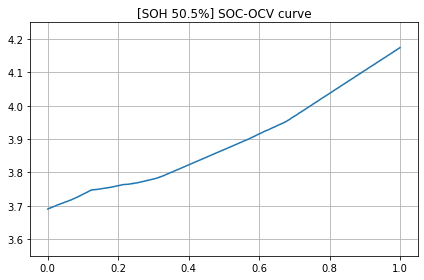

In [94]:
res = 1000
soh_value = 100
soh = np.array([soh_value/100] * res).reshape(-1, 1)
soc = np.linspace(0., 1., res).reshape(-1, 1)
sox = np.concatenate([soh, soc], axis=1)

sox = torch.from_numpy(sox).type(torch.float32)
model.eval()
with torch.no_grad():
    pred_ocv = model(sox.to(device))
    pred_ocv = pred_ocv.detach().cpu().numpy()
    
    
# Plotting
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111)
# ax.set_title(f'[SOH {soh_value:d}%] SOC-OCV curve')
# ax.plot(soc, pred_ocv)
# ax.grid()
# plt.show()

def get_pred_ocv(i):
    soh_value = 100 - i * 0.5
    soh = np.array([soh_value/100] * res).reshape(-1, 1)
    soc = np.linspace(0., 1., res).reshape(-1, 1)
    sox = np.concatenate([soh, soc], axis=1)
    sox = torch.from_numpy(sox).type(torch.float32)
    model.eval()
    with torch.no_grad():
        pred_ocv = model(sox.to(device))
        pred_ocv = pred_ocv.detach().cpu().numpy()
    return pred_ocv
    

plt.figure(facecolor='white')
def animate(i):
    plt.cla()
    plt.xlim([-0.05, 1.05])
    plt.ylim([3.55, 4.25])
    plt.plot(soc, get_pred_ocv(i))
    plt.title(f'[SOH {100-i*0.5}%] SOC-OCV curve')
    plt.grid()
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=100, interval=1)
ani.save('./SOH-SOC-OCV.gif', fps=10)